# LLM Timeseries Forecasting for Physical Systems Example 2: Sine Wave

Because a significant amount of code is shared between this notebook and ```dampedHarmonic.ipynb```, please refer to the former notebook for most structural descriptors. Only changes in approach from ```dampedHarmonic.ipynb``` are annotated in this notebook.

In [294]:
from utils.dataGenerator import dataGenerator
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import os

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Author: Peter Bowman-Davis, Nov 20, 2023                          #
# Timeseries Prediction for Physical Systems Demo                   #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

#Initialize OpenAI API Client

client = OpenAI(api_key='')


# Data Generation

Unlike in ```dampedHarmonic.ipynb```, I introduce a noise into the signal to prevent memorization or simple repetition of the sine wave signal, allowing for a more realistic scenario of forecasting a physical system.

In [295]:
# Define functions to be used
damped_harmonic_oscillator=lambda x: np.exp(-x)*np.sin(2*np.pi*x)
sine_wave=lambda x: np.sin(2*np.pi*x)

# Generate input sequence
dg=dataGenerator(t_max=3.33, samples=51, noise=0.15, fxn=sine_wave)
input=dg.generateStringOutput()

num_train=31

train=input.split(" ")[0:num_train]

test=input.split(" ")[num_train:]


### Train / Test Split

"Train" means the in-context tokens that will be fed to the LLM. "Test" will be used to evaluate MAE in the data analysis stage.

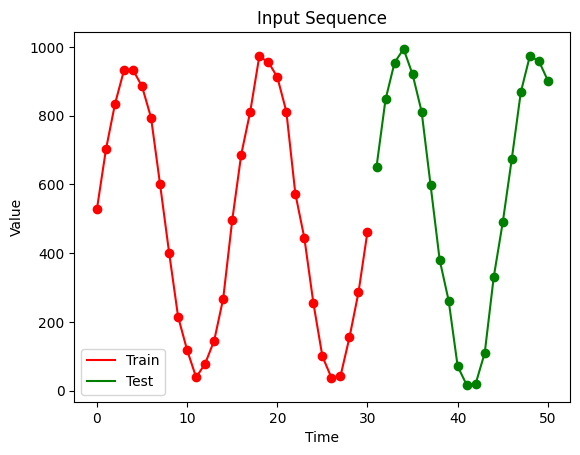

In [296]:
plt.plot(range(0,num_train),[int(y) for y in input.split(" ")[0:num_train]], 'r',label="Train")
plt.plot(range(0,num_train),[int(y) for y in input.split(" ")[0:num_train]], 'ro')
plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'g',label="Test")
plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'go')
plt.title("Input Sequence")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [297]:
def genNextSequence(inputSeq,sysPrompt):
    sysPrompt=sysPrompt
    prompt=inputSeq

    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": sysPrompt},
        {"role": "user", "content": prompt}
    ],
    max_tokens=50,
    n=100
    )
    return completion

### Prompts and Data Structure

In this case, I attempt to not only introduce a description of the generating process from a high level, but also the current state of the system (e.g. the phase). At the end of the analysis, it is shown that the phase description reduces both MAE and MSE, whereas the physical description about the system (e.g. that it is a sinusoid) unexpectedly leads to an increase in MAE and MSE, lending to a mildly confounding datapoint and demonstrating further avenues of exploration for physical system timeseries forecasting.

In [298]:
suffix="Please continue the following sequence without producing any additional text, just return the next twenty numbers."
sysPrompts = {
    "phaseDescriptionOnly": "You are a helpful assistant that performs time series predictions. " + suffix + "Generated values must progressively increase to start.",
    "NoInfoSineWave": "You are a helpful assistant that performs time series predictions. " + suffix,
    "sineWave": "You are a helpful assistant that performs time series predictions on a sinusoidal signal. " + suffix,
    "sineWavePhaseDescription": "You are a helpful assistant that performs time series predictions on a sinusoidal signal. " + suffix + "Generated values must progressively increase to start.",
}

dataByPrompt = { # Key: Prompt, Value: List of Lists of generated samples
    "NoInfo": [],
    "UHO": [],
}

### GPT Call

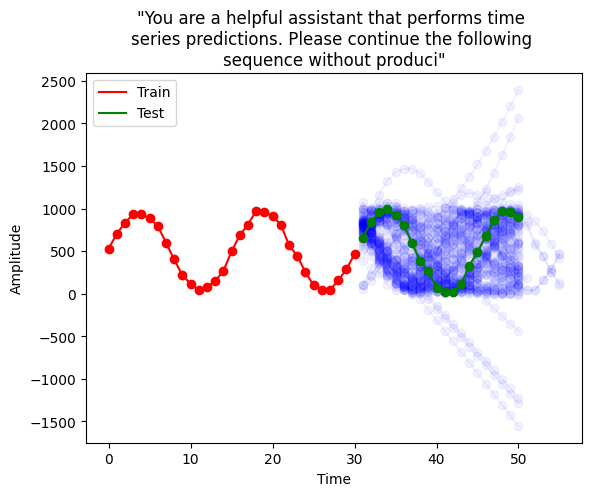

In [299]:
for sysPrompt in sysPrompts.values():
    
    plt.plot(range(0,len(train)),[int(y) for y in train], 'r',label="Train")
    plt.plot(range(0,len(train)),[int(y) for y in train], 'ro')

    generatedSamples=[]
    generatedSamples = []
    i = 0
    for message in genNextSequence(input, sysPrompt).choices:
        try: # Can't win them all – nonstandard response format intrinsic to LLMs requires some data cleaning
            generatedSample = [int(stringNumber) for stringNumber in message.message.content.split(" ") if stringNumber != "" and stringNumber != " "]
            generatedSamples.append(generatedSample)
            
            i += 1  
        except:
            pass

    validGeneratedSamples = []  # List to store only valid sequences

    for generatedSample in generatedSamples:
        if len(generatedSample) == 20:
            validGeneratedSamples.append(generatedSample)
            plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'b', alpha=0.05)
            plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'bo', alpha=0.05)
        elif len(generatedSample) > 20:
            truncatedSample = generatedSample[:20]  # Truncate to the first 20 elements
            validGeneratedSamples.append(truncatedSample)
            plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'b', alpha=0.05)
            plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'bo', alpha=0.05)
        
    
    generatedSamples = validGeneratedSamples

    dataByPrompt[sysPrompt] = generatedSamples


    for key, value in sysPrompts.items():
        if value == sysPrompt:
            sysPromptKey = key
            break
    
    if os.path.exists("./savedData/"+sysPromptKey + '.csv'):
        with open("./savedData/"+sysPromptKey + '.csv', 'a') as f:
            np.savetxt(f, generatedSamples, delimiter=',', fmt='%d')
    else:
        with open("./savedData/"+sysPromptKey + '.csv', 'w') as f:
            np.savetxt(f, generatedSamples, delimiter=',', fmt='%d')


    # Everything below here is just for plotting. 
   
    plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'g',label="Test")
    plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'go')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    
    displaytitle = sysPrompt[0:len(sysPrompt)-len(suffix)]
    
    # Format title to fit on plot
    if len(displaytitle) > 50:
        words = displaytitle.split()
        displaytitle = ""
        current_line = ""
        for word in words:
            if len(current_line) + len(word) <= 50:
                current_line += word + " "
            else:
                displaytitle += current_line + "\n"
                current_line = word + " "
        displaytitle += current_line
    displaytitle = displaytitle[0:len(displaytitle)-1]

    plt.title('"'+displaytitle+'"')
    plt.legend()
    plt.show()

    


### Data Cleaning

Successfully generated 91 samples for prompt "You are a helpful assistant that performs time series predictions. Please continue the following sequence without producing any additional text, just return the next twenty numbers.Generated values must progressively increase to start."


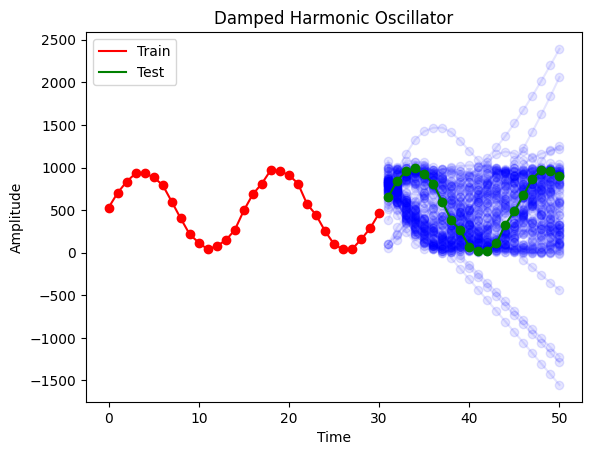

In [300]:
for sysPrompt in sysPrompts.values():
    generatedSamples = dataByPrompt[sysPrompt]
    
    print(f'Successfully generated {len(generatedSamples)} samples for prompt "{sysPrompt}"')

    plt.plot(range(0,len(train)),[int(y) for y in train], 'r',label="Train")
    plt.plot(range(0,len(train)),[int(y) for y in train], 'ro')

    for i in range(len(generatedSamples)):
        plt.plot(range(len(train), len(train) + len(generatedSamples[i])), generatedSamples[i], 'b', alpha=0.1)
        plt.plot(range(len(train), len(train) + len(generatedSamples[i])), generatedSamples[i], 'bo', alpha=0.1)

    plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'g',label="Test")
    plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'go')

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Damped Harmonic Oscillator")
    plt.legend()
    plt.show()



# Data Analysis

We will use a variety of metrics to assess the generated data.

1. MAE – most general descriptor
2. Fraction out of range (e.g has any data x>1000 || x< 0) 
3. Other attributes?

### MAE, MSE, Boundary Checking

[[794, 938, 876, 785, 681, 573, 462, 348, 231, 111, 11, 20, 115, 234, 347, 453, 552, 644, 728, 804], [832, 670, 448, 300, 142, 80, 39, 6, 42, 72, 155, 286, 378, 461, 614, 742, 881, 973, 938, 792], [512, 708, 829, 942, 958, 924, 842, 722, 566, 400, 245, 94, 32, 74, 172, 379, 548, 701, 838, 954], [805, 652, 455, 286, 165, 120, 154, 249, 418, 589, 718, 791, 841, 784, 640, 451, 256, 120, 62, 114], [850, 765, 706, 683, 679, 692, 722, 769, 832, 911, 1005, 1113, 1235, 1370, 1517, 1675, 1843, 2019, 2202, 2392], [979, 804, 622, 447, 348, 234, 115, 202, 439, 639, 847, 939, 997, 929, 825, 654, 523, 322, 190, 83], [817, 812, 807, 802, 797, 792, 787, 782, 777, 772, 767, 762, 757, 752, 747, 742, 737, 732, 727, 722], [760, 925, 990, 968, 882, 748, 560, 352, 185, 108, 58, 82, 161, 304, 506, 687, 822, 920, 965, 954], [650, 749, 815, 841, 829, 770, 677, 568, 462, 361, 267, 182, 106, 40, 30, 95, 210, 378, 514, 603], [1000, 985, 940, 873, 784, 673, 550, 425, 318, 229, 158, 105, 70, 53, 44, 43, 50, 65, 88,

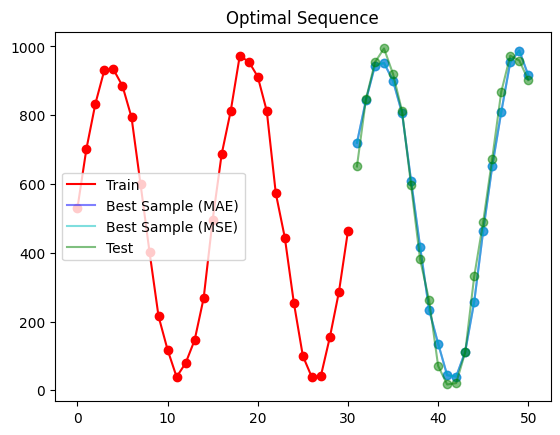

In [301]:
for sysPrompt in sysPrompts.values():
    generatedSamples = dataByPrompt[sysPrompt]
    print(generatedSamples)
    processedGeneratedSamples = [x[0:len(test)] for x in generatedSamples if len(x) >= len(test)]  # Truncate or discard samples based on 'test' length
    testNums = [int(strNum) for strNum in test]

    # Calculate Mean Absolute Error
    MAE = np.mean(np.abs(np.array(processedGeneratedSamples) - np.array(testNums)), axis=1)
    # Calculate Mean Squared Error
    MSE = np.mean((np.array(processedGeneratedSamples) - np.array(testNums))**2, axis=1)

    # Get the index of the best sample based on MAE
    bestSampleIndex_MAE = np.argmin(MAE)
    bestSample_MAE = processedGeneratedSamples[bestSampleIndex_MAE]

    # Get the index of the best sample based on MSE
    bestSampleIndex_MSE = np.argmin(MSE)
    bestSample_MSE = processedGeneratedSamples[bestSampleIndex_MSE]
    
    print(sysPrompt)
    print("Average MAE: ", np.mean(MAE))
    print("Average MSE: ", np.mean(MSE))

    print("Min MAE: ", MAE[bestSampleIndex_MAE])
    print("Min MSE: ", MSE[bestSampleIndex_MSE])

    def checkBounds(sample, upperBound=1000, lowerBound=0):
        for i in range(len(sample)):
            if sample[i] > upperBound or sample[i] < lowerBound:
                return True
        return False

    print("Fraction of samples with values outside of bounds: ", np.mean([checkBounds(sample) for sample in processedGeneratedSamples]))
    print("Fraction of samples with values outside of true bounds: ", np.mean([checkBounds(sample, upperBound=np.max([int(x) for x in test]), lowerBound=np.min([int(x) for x in test])) for sample in processedGeneratedSamples]))



    plt.plot(range(0, len(train)), [int(y) for y in train], 'r', label="Train")
    plt.plot(range(0, len(train)), [int(y) for y in train], 'ro')

    plt.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'b', label="Best Sample (MAE)", alpha=0.5)
    plt.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'bo', alpha=0.5)

    plt.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'c', label="Best Sample (MSE)", alpha=0.5)
    plt.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'co', alpha=0.5)

    test_data_range = range(len(train), len(train) + len(testNums))
    plt.plot(test_data_range, testNums, 'g', label="Test", alpha=0.5)
    plt.plot(test_data_range, testNums, 'go', alpha=0.5)
    plt.title("Optimal Sequence")
    plt.legend()
    plt.show()


# Load Data from ./savedData

#### For n=1000:

NoInfoSineWave.csv
Average MAE:  402.78159999999997
Average MSE:  239009.14919999999
Min MAE:  24.95
Min MSE:  810.15
Fraction of samples with values outside of bounds:  0.077
Fraction of samples with values outside of true bounds:  0.344


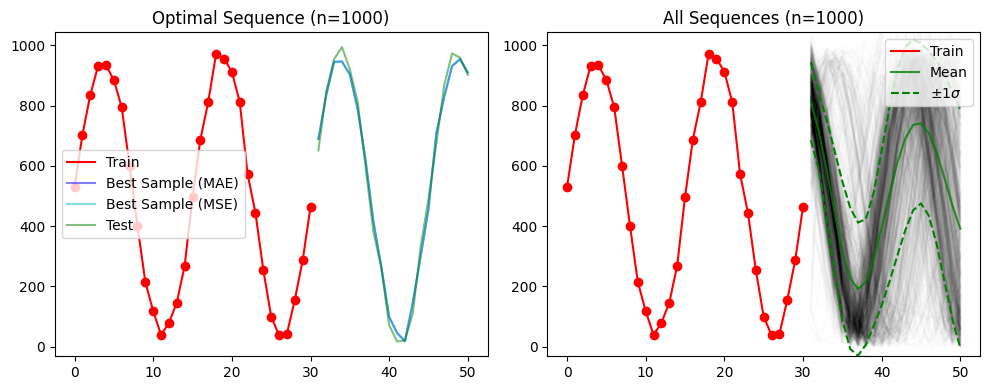

sineWave.csv
Average MAE:  457.9366
Average MSE:  285043.8118
Min MAE:  24.95
Min MSE:  813.7
Fraction of samples with values outside of bounds:  0.09
Fraction of samples with values outside of true bounds:  0.32


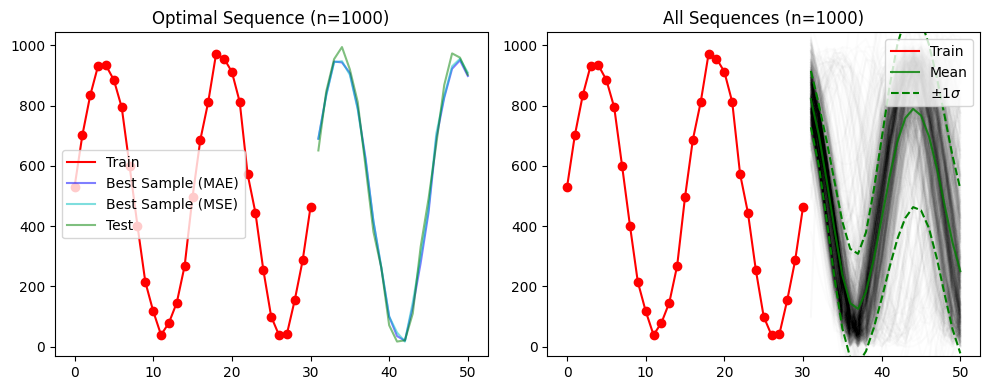

sineWavePhaseDescription.csv
Average MAE:  392.20585000000005
Average MSE:  245892.90635
Min MAE:  24.35
Min MSE:  840.15
Fraction of samples with values outside of bounds:  0.235
Fraction of samples with values outside of true bounds:  0.485


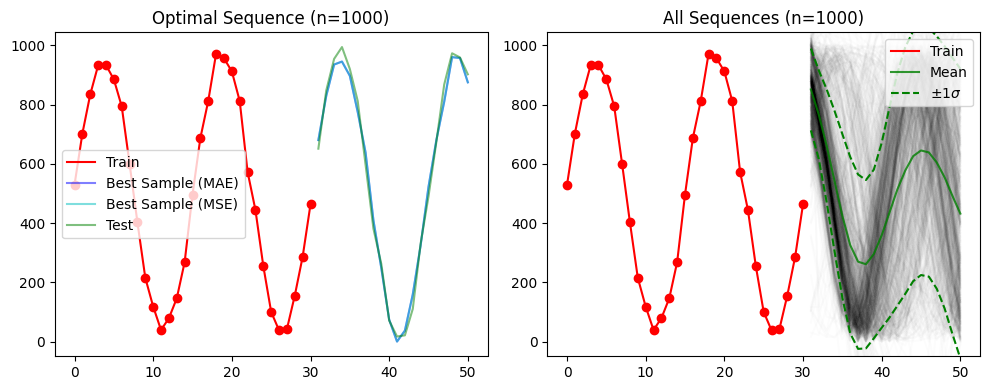

phaseDescriptionOnly.csv
Average MAE:  327.97995000000003
Average MSE:  192303.43675
Min MAE:  21.7
Min MSE:  742.9
Fraction of samples with values outside of bounds:  0.255
Fraction of samples with values outside of true bounds:  0.573


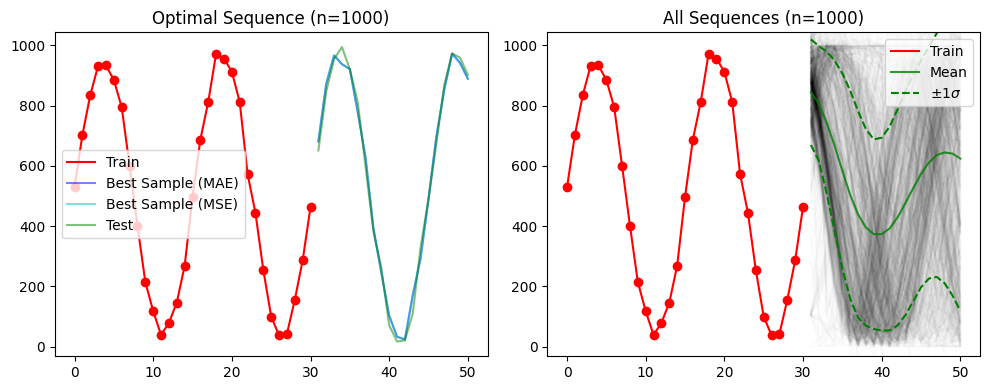

In [302]:

# for datafile in os.listdir("./savedData/"):
for datafile in ["NoInfoSineWave.csv","sineWave.csv","sineWavePhaseDescription.csv","phaseDescriptionOnly.csv"]:
    data_list = []
    with open("./savedData/"+datafile, 'r') as file:
        for line in file:
            int_list = [int(number) for number in line.strip().split(',') if number != '' and number != ' ']
            data_list.append(int_list)
    data_list=data_list[0:1000]
    generatedSamples = data_list
    processedGeneratedSamples = [x[0:len(test)] for x in generatedSamples if len(x) >= len(test)]  # Truncate or discard samples based on 'test' length
    testNums = [int(strNum) for strNum in test]

    # Calculate Mean Absolute Error
    MAE = np.mean(np.abs(np.array(processedGeneratedSamples) - np.array(testNums)), axis=1)
    # Calculate Mean Squared Error
    MSE = np.mean((np.array(processedGeneratedSamples) - np.array(testNums))**2, axis=1)

    

    def checkBounds(sample, upperBound=1000, lowerBound=0):
        for i in range(len(sample)):
            if sample[i] > upperBound or sample[i] < lowerBound:
                return True
        return False
    
    # Get the index of the best sample based on MAE and MSE
    bestSampleIndex_MAE = np.argmin(MAE)
    bestSample_MAE = processedGeneratedSamples[bestSampleIndex_MAE]
    bestSampleIndex_MSE = np.argmin(MSE)
    bestSample_MSE = processedGeneratedSamples[bestSampleIndex_MSE]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    means = np.mean(processedGeneratedSamples, axis=0)
    std_devs = np.std(processedGeneratedSamples, axis=0)

    # First subplot with individual best cases
    ax1.plot(range(0, len(train)), [int(y) for y in train], 'r', label="Train")
    ax1.plot(range(0, len(train)), [int(y) for y in train], 'ro')
    ax1.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'b', label="Best Sample (MAE)", alpha=0.5)
    # ax1.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'bo', alpha=0.5)
    ax1.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'c', label="Best Sample (MSE)", alpha=0.5)
    # ax1.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'co', alpha=0.5)
    test_data_range = range(len(train), len(train) + len(testNums))
    ax1.plot(test_data_range, testNums, 'g', label="Test", alpha=0.5)
    # ax1.plot(test_data_range, testNums, 'go', alpha=0.5)
    ax1.set_title('Optimal Sequence (n=' + str(len(processedGeneratedSamples))+')')
    
    ax1.legend()
    ylim_ax1 = ax1.get_ylim()

  

    # Plot all sequences
    for sample in processedGeneratedSamples:
        ax2.plot(range(len(train), len(train) + len(sample)), sample, 'k', alpha=0.01)

    # Plot training data
    ax2.plot(range(0, len(train)), [int(y) for y in train], 'r', label="Train")
    ax2.plot(range(0, len(train)), [int(y) for y in train], 'ro')

    # Plot mean of all sequences
    ax2.plot(range(len(train), len(train) + len(means)), means, 'g', label="Mean", alpha=0.8)

    # Plot confidence bounds (mean +/- 1 std)
    # ax2.fill_between(range(len(train), len(train) + len(means)), means + std_devs, means - std_devs, color='k', alpha=0.1,label=r"$\pm 1 \sigma$")
    #instead of fill between just do two lines 
    ax2.plot(range(len(train), len(train) + len(means)), means + std_devs, 'g--', label=r"$\pm 1 \sigma$")
    ax2.plot(range(len(train), len(train) + len(means)), means - std_devs, 'g--')

    ax2.set_title('All Sequences (n=' + str(len(processedGeneratedSamples))+')')
    ax2.set_ylim(ylim_ax1)
    ax2.legend(loc='upper right')
    
    plt.tight_layout()


    print(datafile)
    print("Average MAE: ", np.mean(MAE))
    print("Average MSE: ", np.mean(MSE))

    print("Min MAE: ", MAE[bestSampleIndex_MAE])
    print("Min MSE: ", MSE[bestSampleIndex_MSE])
    print("Fraction of samples with values outside of bounds: ", np.mean([checkBounds(sample) for sample in processedGeneratedSamples]))
    print("Fraction of samples with values outside of true bounds: ", np.mean([checkBounds(sample, upperBound=np.max([int(x) for x in test]), lowerBound=np.min([int(x) for x in test])) for sample in processedGeneratedSamples]))

    
    plt.show()

# Conclusion / Analysis: 

As visually apparent in the graphs and metrics above, the addition of the information that the system is sinusoidal alone actually increases error (e.g. decreases forecasting accuracy), whereas the addition of the phase information (that the system starts out by increasing) leads to a decrease in error, though the addition of both of these datapoints leads to a net decrease in error (though relatively marginal) over the baseline (e.g. no information provided). While the sine wave descriptor does increase the relative error, it does – consistent with Example 1 (```dampedHarmonic.ipynb```), lead to a relative decrease in the standard deviation, meaning that the generated sequences tend to be more similar to one another. This may also be observed in the shading of their paths. Thus, the information of the sinusoidal description does not help to decrease the error, but does seem to decrease the spread of the generated data. 

This result leads to a more nuanced view of the integration of physical information into the prompt of a zero-shot timeseries forecaster: arbitrary integration of physical information does not necessarily lead to increases in accuracy of the physical system, but instead, the integration of physical descriptions into a zero-shot timeseries forecaster appears to have different statistical effects on different systems (e.g. lower MAE/MSE, tighter distributions, etc.). As mentioned in Example 1 (```dampedHarmonic.ipynb```), this warrants further investigation for the sake of creating a more unified theory of LLM timeseries forecasting integrating physical information.